*by Sy Dusk, March 2022*

# Introduction

This is a sample A/B test with toy data meant to mimic the analysis for such a test with real data. 

The idea is that we record the the conversion for each of two groups once per day for a certain number of days (ie 90) and then see if there's a significant difference.

I will be using the T-test, Mann Whitney U Test, and Wilcoxon Signed Rank Test to determine statistical ssignificance. I will quantify the uncertainty around the group mean differences with confidence intervals. 

In [1]:
import numpy as np
import pandas as pd

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

# The "Data"

Generate some data with controllable parameters.

In [2]:
# group means
mean_a, mean_b = 0.197, 0.214
# group std devs
sd_a, sd_b = 0.012, 0.019
# length of test
num_days = 90
# random state for reproducibility
rs = 789

In [3]:
rng = np.random.default_rng(rs)
A_vals, B_vals = rng.normal(loc=mean_a, scale=sd_a, size=num_days), rng.normal(loc=mean_b, scale=sd_b, size=num_days)

rates = pd.DataFrame({'A': A_vals, 'B': B_vals},
                     index=pd.date_range(end=pd.to_datetime('today'), freq='D', periods=num_days, normalize=True))
rates

,A,B
2021-12-23,0.204923,0.220975
2021-12-24,0.175810,0.216519
2021-12-25,0.196035,0.209460
2021-12-26,0.202085,0.215457
2021-12-27,0.196527,0.192950
...,...,...
2022-03-18,0.189136,0.230765
2022-03-19,0.186193,0.196051
2022-03-20,0.187654,0.174761
2022-03-21,0.198133,0.225086


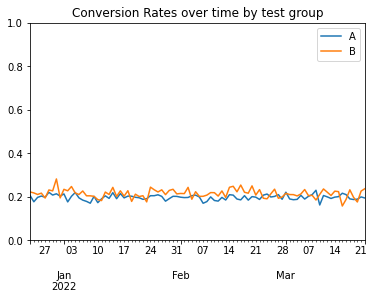

In [4]:
rates.plot()
plt.title('Conversion Rates over time by test group')
plt.ylim(bottom=0, top=1);

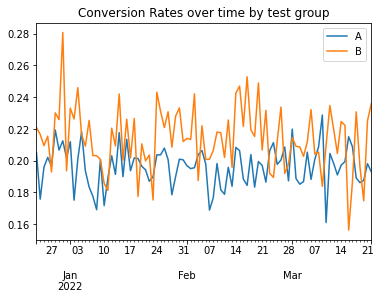

In [5]:
rates.plot()
plt.title('Conversion Rates over time by test group');

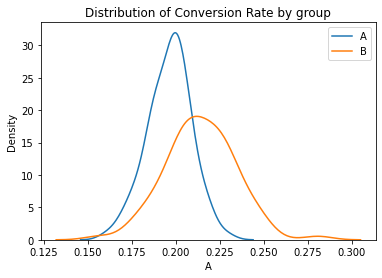

In [6]:
sns.kdeplot(rates['A'], label='A')
sns.kdeplot(rates['B'], label='B')
plt.legend()
plt.title('Distribution of Conversion Rate by group');

In [7]:
rates.mean()

A    0.196295
B    0.214018
dtype: float64

In [8]:
# export the data to csv
rates.to_csv('sample conversion rates.csv')

# Analysis

## T-test

If we didn't know the underlying data were normally distributed, we should check before trying to run a t-test. 

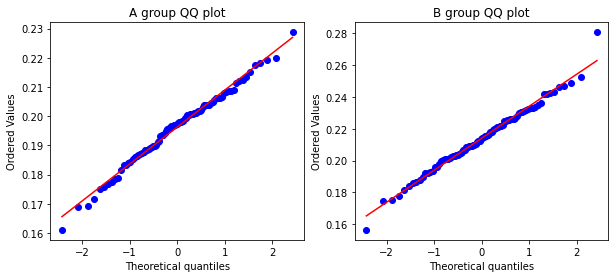

In [9]:
# QQ Plots
fig, axs = plt.subplots(ncols=2, figsize=(10,4))
stats.probplot(rates["A"], plot=axs[0])
axs[0].set_title('A group QQ plot')
stats.probplot(rates["B"], plot=axs[1])
axs[1].set_title('B group QQ plot');

Those distributions look very close to the standard normal. 

In [10]:
# would like to see a ratio less than 2
rates["A"].var() / rates["B"].var()

0.39197921136759

The ratio of the sample variances of the two groups is not too high. 

We can safely make the assumptions needed to run a Student T-test. 

In [11]:
# the t-test
stat, p = stats.ttest_ind(rates["A"], rates["B"])
p

2.4232497898927522e-11

This is a very small p-value indicating that the two group means are significantly different. 

## Nonparamtric test

If the data didn't follow a normal distribution, we could use a nonparametric Mann-Whitney (independence assumption) or Wilcoxon (no assumptions) test. 

In [12]:
stat, p = stats.mannwhitneyu(rates["A"], rates["B"])
p

3.286362128809382e-11

In [13]:
stat, p = stats.wilcoxon(rates["A"], rates["B"])
p

6.814901075779872e-10

Again, the results are highly significant, showing a statistical difference between the group means. 

# Difference between groups and Standard Error

Let's look at the difference between the group means. 

In [14]:
rates['diff'] = (rates['B'] - rates['A'])

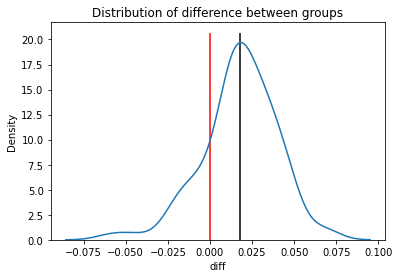

In [15]:
sns.kdeplot(x=rates['diff']).set(title='Distribution of difference between groups')
bottom, top = plt.gca().get_ylim()
plt.vlines(rates['diff'].mean(), ymin=bottom, ymax=top)
plt.vlines(0, ymin=bottom, ymax=top, color='r');

In [16]:
diff_mean = rates['diff'].mean()
diff_mean

0.01772327759985595

This is the mean difference between conversion rates in the two groups. 

In [17]:
se = rates['diff'].std() / np.sqrt(len(rates['diff']))
se

0.002316566306088084

The SE tells us the spread of the distribution around the mean. 

# Confidence Interval for the difference between means

We can construct a confidence interval around this difference between the mean conversion rates. 

In [18]:
Z = 1.96 # 95% confidence level
lower, upper = diff_mean - Z*se, diff_mean + Z*se
lower, upper

(0.013182807639923303, 0.022263747559788594)

This is a very tight 99% CI and does not include 0 meaning the A/B test strong differentiates the groups. 

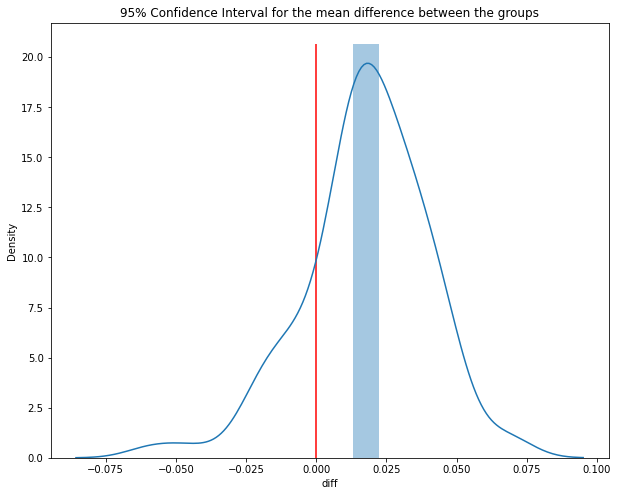

In [19]:
# make plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.kdeplot(x=rates['diff'], ax=ax).set(title='Distribution of difference between groups')
bottom, top = ax.get_ylim()
plt.vlines(0, ymin=bottom, ymax=top, color='r')
plt.fill_between(x=[lower, upper], y1=[top, top], alpha=0.4)
ax.set_title(f'95% Confidence Interval for the mean difference between the groups');

For grins we can check this against the true difference between the underlying population means, which we normally wouldn't have access to.

In [20]:
mean_b - mean_a

0.016999999999999987

In [21]:
lower, upper

(0.013182807639923303, 0.022263747559788594)

We can see that the true population mean difference lies within the confidence interval. 

# Conclusion

The analysis showed a statistically significant difference between the A and B groups. 

The B group showed a signficantly higher conversion. 

# Repeatability

If we want to run this analysis multiple times with different parameters it would be nice to have it wrapped in a single process.

In [22]:
def generate_ab_data(mean_a, sd_a, mean_b, sd_b, num_days=90, rs=789):
    rng = np.random.default_rng(rs)
    A_vals, B_vals = rng.normal(loc=mean_a, scale=sd_a, size=num_days), rng.normal(loc=mean_b, scale=sd_b, size=num_days)
    rates = pd.DataFrame({'A': A_vals, 'B': B_vals},
                     index=pd.date_range(end=pd.to_datetime('today'), freq='D', periods=num_days, normalize=True))
    rates['diff'] = rates['B'] - rates['A']
    return rates

def plot_ab_dist(df):
    fig, axs = plt.subplots(ncols=2, figsize=(14, 6))
    # first plot
    sns.kdeplot(df['A'], label='A', ax=axs[0])
    sns.kdeplot(df['B'], label='B', ax=axs[0])
    axs[0].legend()
    axs[0].set_title('Distribution of Conversion Rate by group')
    # second plot
    sns.kdeplot(x=df['diff'], ax=axs[1]).set(title='Distribution of difference between groups')
    bottom, top = axs[1].get_ylim()
    plt.vlines(rates['diff'].mean(), ymin=bottom, ymax=top)
    plt.vlines(0, ymin=bottom, ymax=top, color='r');

def plot_qq(df):
    # QQ Plots
    fig, axs = plt.subplots(ncols=2, figsize=(14,6))
    stats.probplot(df["A"], plot=axs[0])
    axs[0].set_title('A group QQ plot')
    stats.probplot(df["B"], plot=axs[1])
    axs[1].set_title('B group QQ plot');
    # would like to see a ratio less than 2
    return df["A"].var() / df["B"].var()

def ab_significance(df):
    ps = {}
    # the t-test
    _, p = stats.ttest_ind(df["A"], df["B"])
    ps['T-test'] = p
    # Mann Whitney U test
    _, p = stats.mannwhitneyu(df["A"], df["B"])
    ps['Mann Whitney'] = p
    # Wilcoxon
    _, p = stats.wilcoxon(df["A"], df["B"])
    ps['Wilcoxon'] = p
    return ps

def plot_ci(df, sig='99'):
    # get CI's
    Zs = {'99': 2.58, '95': 1.96, '90': 1.65}
    assert sig in list(Zs.keys())
    Z = Zs[sig]
    se = df['diff'].std() / np.sqrt(len(df))
    S2 = se**2
    lower, upper = diff_mean - Z*se, diff_mean + Z*se
    # make plot
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.kdeplot(x=df['diff'], ax=ax).set(title='Distribution of difference between groups')
    bottom, top = ax.get_ylim()
    plt.vlines(0, ymin=bottom, ymax=top, color='r')
    plt.fill_between(x=[lower, upper], y1=[top, top], alpha=0.4)
    ax.set_title(sig+f'% Confidence Interval for the mean difference between the groups');
    return lower, upper

We can generate some toy data that is less differentiated and run the same analysis. 

In [23]:
# generate data
toy_data = generate_ab_data(mean_a=0.217, sd_a=0.035, 
                            mean_b=0.234, sd_b=0.042, 
                            num_days=21)

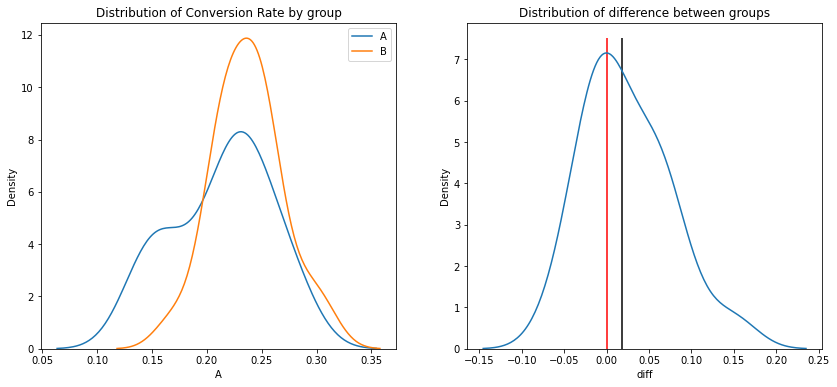

In [24]:
# visualize
plot_ab_dist(toy_data)

1.9851468915065655

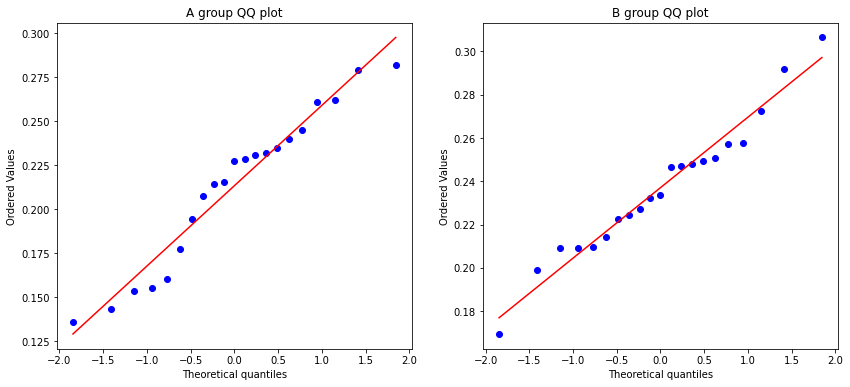

In [25]:
# check normality assumptions for t-test
plot_qq(toy_data)

In [26]:
# run statistical tests
ab_significance(toy_data)

{'Mann Whitney': 0.059420610473384164,
 'T-test': 0.05292756389987242,
 'Wilcoxon': 0.08534092651572474}

(-0.011201433411061518, 0.04664798861077342)

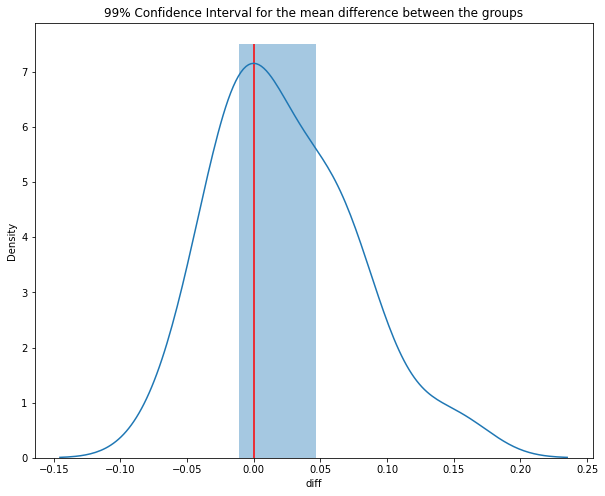

In [27]:
# get confidence intervals
plot_ci(toy_data)